In [1]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from photutils.detection import find_peaks
import itertools

In [8]:
img1 = Image.open("../../ThorlabsImages/imgs/lightsOn_LEDOff/20251110_174106_1000000.tif")
img2 = Image.open("../../ThorlabsImages/imgs/lightsOn_LEDOn/20251110_175019_1000000.tif")
img3 = Image.open("../../ThorlabsImages/imgs/lightsOff_LEDOff/20251110_180442_1000000.tif")
img4 = Image.open("../../ThorlabsImages/imgs/lightsOff_LEDOn/20251110_175728_1000000.tif")

In [16]:
# mean,median,std = sigma_clipped_stats(img,sigma=2)

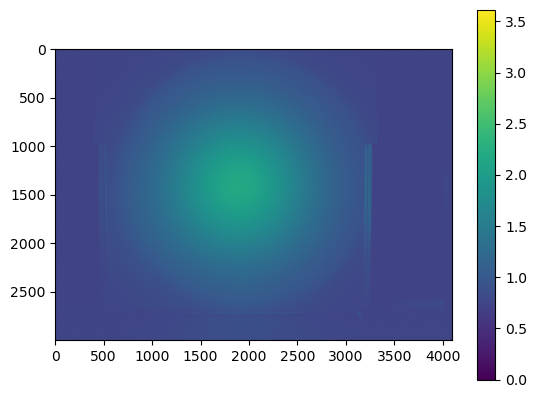

In [12]:
plt.imshow(np.log10(np.array(img1)),)
plt.colorbar()

/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_31009/3692806174.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.array(img2,dtype=np.int32)-np.array(img1,dtype=np.int32)),)
/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_31009/3692806174.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.array(img2,dtype=np.int32)-np.array(img1,dtype=np.int32)),)


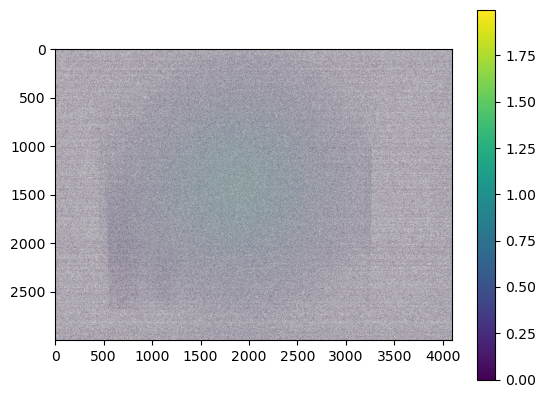

In [43]:
plt.imshow(np.log10(np.array(img2,dtype=np.int32)-np.array(img1,dtype=np.int32)),)
plt.colorbar()


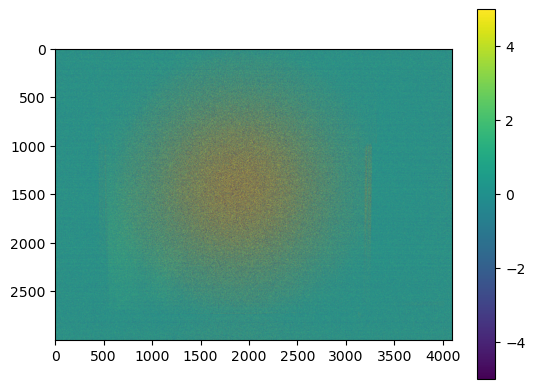

In [38]:
plt.imshow(np.array(img2,dtype=np.int16) - np.array(img1,dtype=np.int16),vmin=-5,vmax=5)
plt.colorbar()

In [70]:
np.nanpercentile(np.array(img3,dtype=np.int32),[0,0.01,1,50,99.9,100])

array([1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 1.300e+01, 4.094e+03])

Text(0.5, 0, 'intensity [counts]')

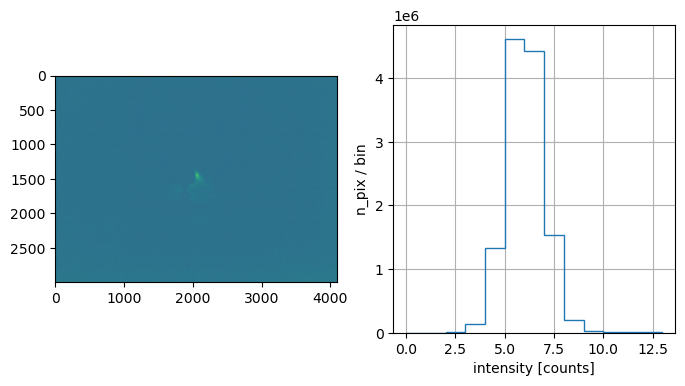

In [73]:
fig,axs = plt.subplots(1,2,figsize=(8,4))

cax=axs[0].imshow(np.array(img3,dtype=np.int32),vmin=1,vmax=13)
# plt.colorbar()

axs[1].hist(np.array(img3,dtype=np.int32).flatten(),bins=np.arange(0,14),histtype='step')
axs[1].grid()
axs[1].set_ylabel("n_pix / bin")
axs[1].set_xlabel("intensity [counts]")

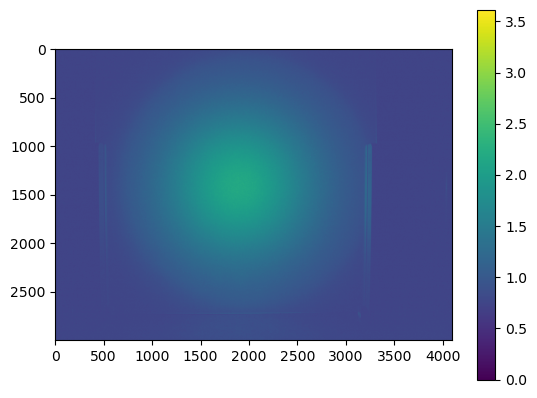

In [45]:
plt.imshow(np.log10(np.array(img4)),)
plt.colorbar()


## Make a mask of the diffuser ROI

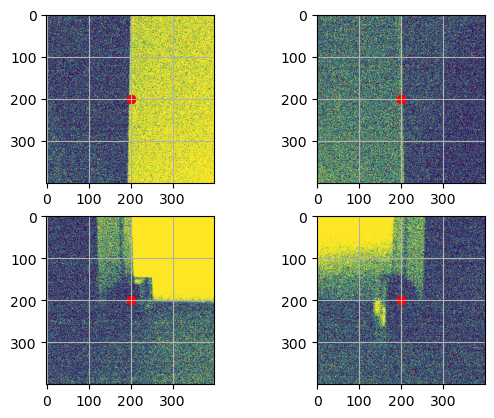

In [5]:
fig,axs = plt.subplots(2,2)

buff=200
corners = np.array([
    [385,buff],
    [3265,buff],
    [510,2720], # This looks good
    [3150,2710]
])


for ax,c in zip(axs.flatten(),corners):
    ax.imshow(np.array(img)[c[1]-buff:c[1]+buff,c[0]-buff:c[0]+buff],vmin=5,vmax=8)
    ax.scatter(buff,buff,marker='o',color='red')
    ax.grid()

In [6]:
for i in range(len(corners)):
    if corners[i][1]==buff:
        corners[i][1]=0

In [7]:
corners

array([[ 385,    0],
       [3265,    0],
       [ 510, 2720],
       [3150, 2710]])

In [8]:
simpleCorners = np.array([
    [ 447,    0],
    [3197,    0],
    [ 447, 2715],
    [3197, 2715]])

xc = [447,3197]
yc = [0,2715]

mask = np.ones(np.shape(np.array(img)))
prevFirst,prevSecond = xc[-1],yc[-1]
for firstC in xc:
    for secondC in yc:
        mask[prevSecond:secondC,prevFirst:firstC] = 0
        prevSecond = secondC
    prevFirst = firstC

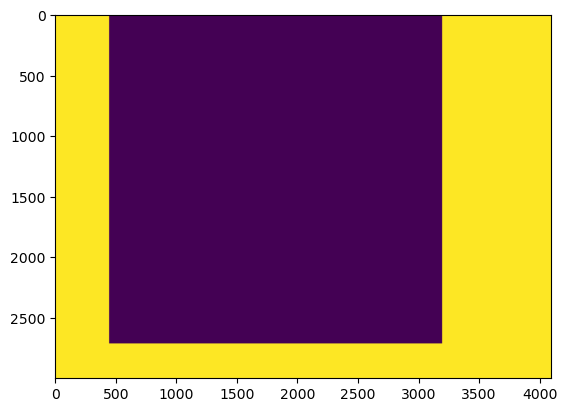

In [9]:
plt.imshow(mask)

## Now do a crude spotfinding

In [61]:
percLim = 75

In [62]:
threshold = np.nanpercentile(np.array(img),[percLim])[0]

In [63]:
myImg = np.array(img,dtype=np.int64)
myImg[myImg-threshold < 0] = 0

In [64]:
num_max=200

In [65]:
indices = np.array(np.unravel_index(np.argsort(myImg.flatten())[::-1][:num_max],myImg.shape))

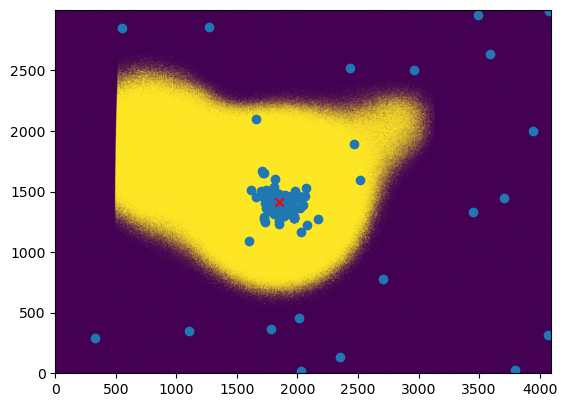

In [66]:
plt.scatter(indices[1],indices[0],marker='o')
plt.scatter(np.median(indices[1]),np.median(indices[0]),marker='x',color='red')
plt.imshow(myImg,vmin=0,vmax=16,origin="lower")

## Try using `find_peaks`

In [67]:
tbl = find_peaks(np.array(myImg), threshold, box_size=1000)
maxTbl = tbl[np.argmax(tbl[tbl["peak_value"]!=4094]["peak_value"])]
# positions = np.transpose((tbl['x_peak'], tbl['y_peak']))

In [68]:
tbl

id,x_peak,y_peak,peak_value
int64,int64,int64,int64
1,3278,3,189
2,330,290,3258
3,4071,317,309
4,1106,350,2431
5,2009,457,1737
6,2710,777,4094
7,422,1061,179
8,1972,1284,338
9,3449,1331,302


In [69]:
np.std(myImg)

np.float64(29.239582576781327)

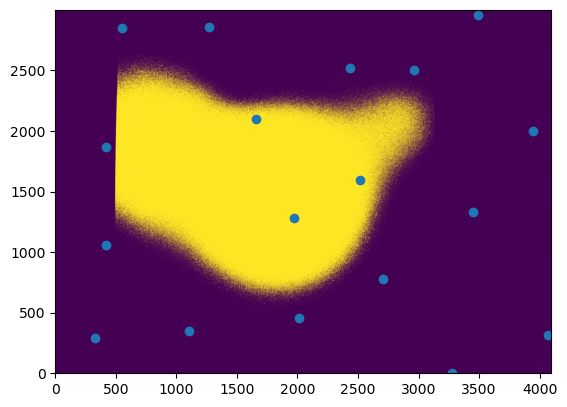

In [70]:
plt.imshow(myImg,vmin=0,vmax=16,origin="lower")
plt.scatter(tbl['x_peak'],tbl['y_peak'])

## Try using DAOStarFinder

In [71]:
np.nanpercentile(myImg,[0,1,5,50,95,99,100]),np.unique(myImg.flatten())

(array([   0.,    0.,    0.,    0.,   74.,  130., 4094.]),
 array([   0,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
          40,   41,   42,   43,   44,   45,   46,   47,   48,   49,   50,
          51,   52,   53,   54,   55,   56,   57,   58,   59,   60,   61,
          62,   63,   64,   65,   66,   67,   68,   69,   70,   71,   72,
          73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
          95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
         106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
         117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
         128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,
         139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  149,
         150,  151,  152,  153,  154,  155,  156,  157,  158,  159,  160,
         161,  162,  163,  164,  165,  166,  167,  16

(array([0.00000e+00, 0.00000e+00, 9.25167e+05, 6.39580e+05, 5.49496e+05,
        2.82799e+05, 1.54780e+05, 1.15838e+05, 9.30320e+04, 7.86800e+04,
        6.63450e+04, 5.58220e+04, 4.48540e+04, 3.23030e+04, 2.15690e+04,
        1.31140e+04, 7.36300e+03, 3.83100e+03, 1.91200e+03, 9.52000e+02,
        4.35000e+02, 2.14000e+02, 9.60000e+01, 4.40000e+01, 2.20000e+01,
        1.10000e+01, 8.00000e+00, 7.00000e+00, 3.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

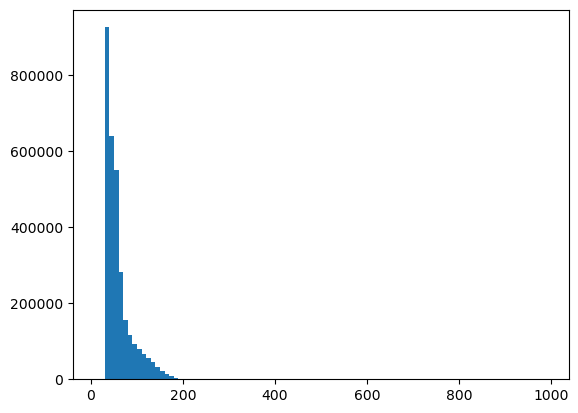

In [73]:
plt.hist(myImg.flatten()[myImg.flatten()>0],bins=np.arange(10,1000,step=10))

In [74]:
nativeMask = mask.astype(int).tolist()

In [75]:
daofind = DAOStarFinder(fwhm=50, threshold=100,brightest=1)
# ,xycoords=[[np.median(indices[1]),np.median(indices[0])]],
                        # sharplo=0,brightest=1,

In [76]:
%%time
sources = daofind(myImg,mask=nativeMask,)

CPU times: user 1min 24s, sys: 183 ms, total: 1min 24s
Wall time: 1min 24s


In [77]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64
1,1925.9816394616635,1440.5040829987386,0.23386283935494945,0.8112720591532014,-0.2863227307051373,3969,157,608522,-14.460690709931592,-0.6191889933591154


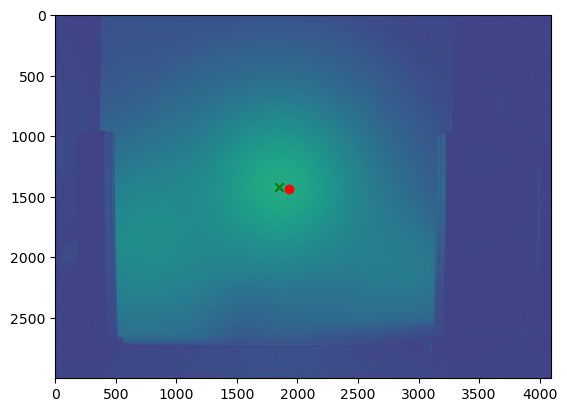

In [79]:
plt.imshow(np.log10(np.array(img)))
plt.scatter(sources["xcentroid"],sources["ycentroid"],marker='o',color='red')
plt.scatter(np.median(indices[1]),np.median(indices[0]),marker='x',color='green')

In [90]:
difference = np.sqrt((sources['xcentroid']-np.median(indices[1]))**2 + (sources['ycentroid']-np.median(indices[0]))**2)
print(f"Difference between two centroid finding algorithms: {difference.value[0]} pix")

Difference between two centroid finding algorithms: 81.92563487823652 pix


## Steps from here:
- Take a standardized set of images, without positioner movement, and evaluate the two centroid finding algorithms.
    - Likely DAO will win, since there are inherent flaws in the version I cooked up offhand, but it would be good to see what the variance of the measurement is for the static case
- Repeat measurement with 'winning' algorithm with movement of positioner to see if blob movement can be detected within expectation.